# `Predicting outcomes for passengers`<br>
Baseline, Hypothesis testing for feature selection and model improvement

In this notebook, we want to assess how well our model perform to predict the inrjury level for passengers. Will will improve the model by adding hypothesis testing for feature selection and try to improve our score

In [1]:
#Importing data manipulation and visualization libraries
import pandas as pd # for dataframe manipulation
import numpy as np # for numbers manipulations


import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visualization
import scipy.stats as stats # # we never just "import scipy" as all the juice is in the submodules

import plotly.express as px # for data visualization
import plotly.figure_factory as ff# for data visualization

from sklearn.preprocessing import LabelEncoder,FunctionTransformer,StandardScaler #for data preprocessing and scaling
from sklearn.feature_selection import chi2 #for hypothesis testing on categorical variables
from sklearn.pipeline import Pipeline #for chaining operations prior to the gridsearch

from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV #for modeling preparation

#importing our models
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier, plot_importance

#importing metrics to evaluate models performance
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import  precision_score, recall_score, roc_auc_score, accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay, RocCurveDisplay, plot_roc_curve 
from imblearn.metrics import specificity_score

import warnings
warnings.filterwarnings("ignore")

# to access AWS
import aws_creds
import os
from smart_open import smart_open
import boto3 
from io import StringIO # python3; python2: BytesIO 

#check time it takes to run the entire notebook
import time
st = time.time()

Helper functions

In [2]:
#this function will fit models and generate visualization
def meta_func (model,model_name,param_grid,X_train,y_train,X_test,y_test,score_dict):
        #model
        gs_model = GridSearchCV(
        model,
        param_grid=param_grid,
        cv=3,
        verbose=1,
        n_jobs=-1
        )

        #fitting model -------------------------------------------------------
        gs_model.fit(X_train,y_train)

        #getting predictions
        train_preds = gs_model.predict(X_train)
        preds = gs_model.predict(X_test)
        
        #getting the test metrics ready
        test_f1score=f1_score(y_test,preds)
        test_precision=precision_score(y_test,preds)
        test_accuracy=accuracy_score(y_test,preds)
        test_recall=recall_score(y_test,preds)
        test_roc_auc=roc_auc_score(y_test,preds)
        test_specificity = specificity_score(y_test,preds)

        #getting the train metrics
        train_f1score=f1_score(y_train,train_preds)
        train_specificity = specificity_score(y_train,train_preds)
        train_precision=precision_score(y_train,train_preds)
        train_accuracy=accuracy_score(y_train,train_preds)
        train_recall=recall_score(y_train,train_preds)
        train_roc_auc=roc_auc_score(y_train,train_preds)
        #printing results-----------------------------------------------------------------

        print(f'best params : {gs_model.best_params_}')

        print(f'Test_f1_score : {test_f1score}')
        print(f'Test_precision score : {test_precision}')
        print(f'Test_accuracy score : {test_accuracy}')
        print(f'Test_recall score : {test_recall}')
        print(f'Test_roc_auc score : {test_roc_auc}')
                
        # #update various metrics onto results list-------------------------------------------------------------
        score_dict[model_name] = {
                'Train_acc':train_accuracy,
                'Test_acc':test_accuracy,
                'Train_recall':train_recall,
                'Test_recall':test_recall,
                'Train_preci':train_precision,
                'Test_preci':test_precision,
                'Train_f1score':train_f1score,
                'Test_f1score':test_f1score,
                'Train_roc_auc':train_roc_auc,
                'Test_roc_auc':test_roc_auc,
                'Train_specificity': train_specificity,
                'Test_specificity':test_specificity
                }

        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        cm = confusion_matrix(y_test,preds)
        displ = ConfusionMatrixDisplay(cm)
        displ.plot();

        plot_roc_curve(gs_model.best_estimator_, X_test, y_test)
        plt.plot([0, 1], [0, 1],
        label='baseline', linestyle='--') # to simulate random guess 
        plt.legend();

        return gs_model

In [3]:
#Helper functions - showing dataframe quality
def df_quality (df):
    df_qual= pd.DataFrame(df.dtypes, columns={'dtypes'}) # creating a colum to display all data types
    df_qual['isna%'] = np.round((df.isna().sum()/len(df))*100,1) # creating new columns = to missing values %
    df_qual['isna']= df.isna().sum()
    df_qual['unique']=df.nunique() # creating new columns eq to missing values
    return df_qual.sort_values(by= 'isna%' , ascending=False)[:40] # sorting and shortlisting

In [4]:
#function to test for statistical significance, and chosing the right test depending on data distribution
#borrowed from Shilpa's github  -https://github.com/shilpaleo/employee_resignation_prediction/blob/main/notebook/Resignation%20Case%20Study.ipynb

def cont_stat_sig_test(df,col):
    # defining function for normality + statistical significance check
    # Step 1: normality test
    stat, p_value = stats.normaltest(df[col].values)
    
    # Step 2: filter series    
    df_ok = df[df['injury_level']=='OK'][col].values
    df_not_ok = df[df['injury_level']=='not_ok'][col].values
    
    # Step 3: determining appropriate statistical significance test based on normality
    if p_value>0.01:
        distribution = 'normal distribution'
        test = 'Anova test'
        stat, p_value = stats.f_oneway(df_ok, df_not_ok)
    
    else:
        distribution = 'non-normal distribution'
        test = 'KS test'
        stat, p_value = stats.ks_2samp(df_ok, df_not_ok)
    
    # Step 4: conclude on statistical significance
    if p_value>0.05:
        sig = 'not statistically significant'
    else:
        sig = 'statistically significant'

    print(f'{col} has {distribution}: running {test}. result: {sig}')
    return p_value


In [5]:
#dictionary to store our results
score_dict_passengers={}

### 1. Preping data for 1st run

Importing file

In [6]:
#importing our file from AWS
aws_key = aws_creds.aws_key
aws_secret = aws_creds.aws_secret

bucket_name = aws_creds.bucket
object_key = 'df_eda.csv'

path = 's3://{}:{}@{}/{}'.format(aws_key, aws_secret, bucket_name, object_key)

df = pd.read_csv(smart_open(path), index_col=[0]) # index_col=[0] to avoid unammed:0

In [7]:
df['injury_level'] = df['injury_level'].map({'OK':1,'not_ok':0}) #mapping target variable
df_pass = df[(df['user_type']=='passenger')] # targeting passengers
df_pass['injury_level'].value_counts()

1    54628
0    10898
Name: injury_level, dtype: int64

In [8]:
df_quality (df_pass)

,dtypes,isna%,isna,unique
pedestrian_loc,object,100.0,65526,0
pedestrian_action,object,100.0,65526,0
pedestrian_group,object,100.0,65526,0
reserved_path,object,93.1,60986,2
infra_type,object,83.7,54869,9
fixed_obstacle_hurt,object,73.8,48327,15
safety_feat_2,object,53.0,34708,9
width_road_only,object,36.8,24088,129
mobile_obstacle_hurt,object,29.4,19256,6
journey_reason,object,25.6,16760,6


Let's clear the NaN before fitting models. Given the NaNs identified above and the information contained in the columns, we make the choice to cut any feature with more than 10% NaN

In [9]:
#Let's remove all 10% above NaN features
high_nans = [col for col in df_pass.columns if ((df_pass[col].isna().sum()/len(df_pass)))>0.1]
df_pass = df_pass.drop(columns = high_nans)
print(f'after dropping high_nan features, shape is : {df_pass.shape}')

#then we drop any columns with NaNs remaining 
df_pass = df_pass.dropna()
print(f'after dropping high_nan and remaining nan, shape is: {df_pass.shape}')

#finally, we manually renmove these columns as they are either duplicates or strongly correlated to other features
pass_cols_todrop = [
    'acc_num', # not informative 
    'id_vehicule', #not informative
    #'seat',only valid for passengers and passengers
    'user_type',# already filtered on passengers + passengers
    'day',#duplicate with day of the week and month
    'year',# dropping year but keeping month for seasonality
    'lat',#duplicate with geo
    'long', #duplicate with geo
    'date',#duplicate with day of the week and Month - we do not need that much details
    'hhmm',#already captured in hh
    'YYYY-MM',#another date duplicate only used for EDA
    'country',#not informative
    'lane_num',
    'max_speed_allowed', # we are going with speed_group instead
    'city',
    'age',
    'geo',
    'dob',
    'postal_address',
    'department_fr']

df_pass = df_pass.drop(columns = pass_cols_todrop)
print(f'after dropping duplicates, final shape is : {df_pass.shape}')

after dropping high_nan features, shape is : (65526, 47)
after dropping high_nan and remaining nan, shape is: (43267, 47)
after dropping duplicates, final shape is : (43267, 28)


In [10]:
df_quality(df_pass)

,dtypes,isna%,isna,unique
seat,object,0.0,0,9
injury_level,int64,0.0,0,2
vehi_grp,object,0.0,0,3
speed_group,float64,0.0,0,7
event,object,0.0,0,12
hour,int64,0.0,0,24
day_of_week,object,0.0,0,7
collision_type,object,0.0,0,7
weather,object,0.0,0,9
crossing,object,0.0,0,5


In [11]:
#preparing our X and y
X = df_pass.drop(columns='injury_level')
y=df_pass['injury_level']

In [12]:
##encoding categorical variables
X = pd.get_dummies(X, columns=X.select_dtypes('object').columns, drop_first=True)
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42, test_size=0.2, stratify=y)
print(X.shape)

(43267, 137)


### 2. Modeling

#### Logistic Regression

Fitting 3 folds for each of 4 candidates, totalling 12 fits
best params : {'lr__C': 0.2, 'lr__class_weight': 'balanced', 'lr__penalty': 'l1'}
Test_f1_score : 0.8134542354491203
Test_precision score : 0.9396598030438675
Test_accuracy score : 0.72186272244049
Test_recall score : 0.7171358294616015
Test_roc_auc score : 0.7324451602397828
CPU times: total: 11.8 s
Wall time: 1min 10s


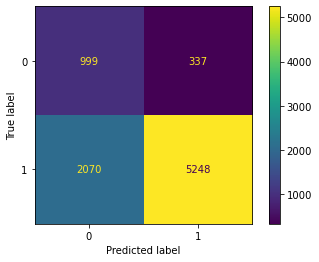

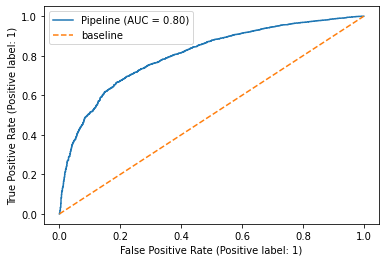

In [13]:
%%time
model = meta_func (
    model=
        Pipeline(
    [
    ('ss',StandardScaler()),
    ('lr', LogisticRegression(random_state=42, solver='saga'))
    ]
)
,
    model_name='lr_1st_round',
    param_grid=
    {"lr__penalty":['l1','l2'],
    "lr__C":[0.2,0.3],#Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
    "lr__class_weight":['balanced']     
    }
,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_passengers
)

In [14]:
#extract top features
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.steps[-1][1].coef_[0]})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
16,vehicule_type_bus,0.240557
36,impact_location_rear,0.228172
72,travelling_direction_unidirectional,0.225996
109,collision_type_three_or_more_vehicules_chain,0.222251
58,was_doing_turning,0.204738
...,...,...
22,vehicule_type_moto,-0.223425
136,age_group_80_over,-0.236011
95,in_out_city_out_of_city,-0.240361
135,age_group_60_80,-0.250895


#### AdaBoost

Fitting 3 folds for each of 4 candidates, totalling 12 fits
best params : {'learning_rate': 1, 'n_estimators': 150}
Test_f1_score : 0.91743708269132
Test_precision score : 0.8652216032937757
Test_accuracy score : 0.8513981973653801
Test_recall score : 0.9763596611095928
Test_roc_auc score : 0.5716379143871317
CPU times: total: 17.4 s
Wall time: 1min 45s


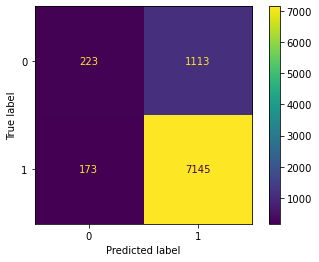

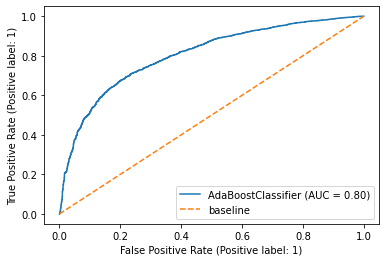

In [15]:
%%time
model = meta_func (
    model=AdaBoostClassifier(random_state=42)
,
    model_name='abc_1st_round',
    param_grid=
{
    'n_estimators': [150,300], 
    'learning_rate': [1, 2]
    }
,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_passengers
)

In [16]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.feature_importances_})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
1,num_operating_lanes,0.086667
4,speed_group,0.073333
3,hour,0.066667
95,in_out_city_out_of_city,0.040000
36,impact_location_rear,0.026667
...,...,...
96,crossing_others,0.000000
32,vehicule_type_tramway,0.000000
99,crossing_train_crossing,0.000000
100,weather_fog,0.000000


#### XGBoost

Fitting 3 folds for each of 8 candidates, totalling 24 fits
best params : {'learning_rate': 0.5, 'max_depth': 2, 'min_split_loss': 1}
Test_f1_score : 0.9179970507148811
Test_precision score : 0.8647179611064139
Test_accuracy score : 0.8522070718742778
Test_recall score : 0.9782727521180651
Test_roc_auc score : 0.569974699412326
CPU times: total: 21.6 s
Wall time: 56.9 s


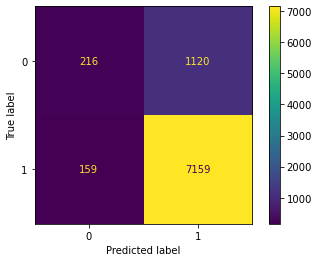

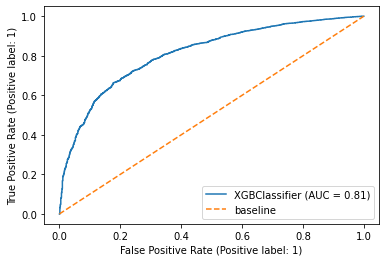

In [17]:
%%time
model = meta_func (
    model=XGBClassifier(random_state=42)
,
    model_name='xgb_1st_round',
    param_grid=
{
    'learning_rate': [0.5,1], 
    'min_split_loss': [1,2], #The larger gamma is, the more conservative the algorithm will be
    'max_depth':[2,3] #Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
     # Beware that XGBoost aggressively consumes memory when training a deep tree
    }
,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_passengers
)

In [18]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.feature_importances_})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
89,road_location_accident_road,0.128886
95,in_out_city_out_of_city,0.063680
22,vehicule_type_moto,0.058320
36,impact_location_rear,0.058056
108,collision_type_other_collision,0.056989
...,...,...
99,crossing_train_crossing,0.000000
100,weather_fog,0.000000
101,weather_heavy_rain,0.000000
103,weather_light_rain,0.000000


#### Linear Support Vectors Classifiers

Fitting 3 folds for each of 24 candidates, totalling 72 fits
best params : {'lsvc__C': 0.1, 'lsvc__dual': True, 'lsvc__max_iter': 500, 'lsvc__penalty': 'l2'}
Test_f1_score : 0.8133622694155946
Test_precision score : 0.9396489971346705
Test_accuracy score : 0.7217471689392189
Test_recall score : 0.7169991801038536
Test_roc_auc score : 0.7323768355609088
CPU times: total: 10.3 s
Wall time: 1min 58s


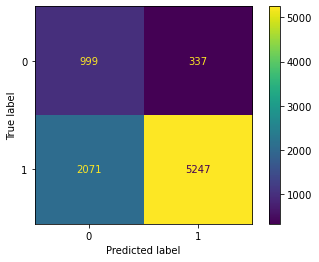

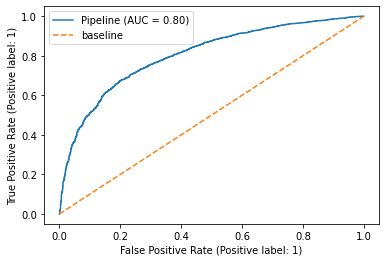

In [19]:
%%time
model = meta_func (
    model=Pipeline(
        [
            ('ss',StandardScaler()),
            ('lsvc', LinearSVC(class_weight='balanced'))
        ]
    ),
    model_name='lsvc_1st_round',
    param_grid=
{   'lsvc__max_iter':[500,1000],
    'lsvc__C': [0.001,0.01,0.1], 
    'lsvc__dual': [True, False],     
    'lsvc__penalty':['l1','l2']   
},
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_passengers
)

#### Checking our baseline models

In [20]:
passengers_score_df= pd.DataFrame(score_dict_passengers).T
passengers_score_df

,Train_acc,Test_acc,Train_recall,Test_recall,Train_preci,Test_preci,Train_f1score,Test_f1score,Train_roc_auc,Test_roc_auc,Train_specificity,Test_specificity
lr_1st_round,0.716638,0.721863,0.711709,0.717136,0.938291,0.939660,0.809442,0.813454,0.727673,0.732445,0.743638,0.747754
abc_1st_round,0.847254,0.851398,0.975196,0.976360,0.862222,0.865222,0.915236,0.917437,0.560858,0.571638,0.146519,0.166916
xgb_1st_round,0.851472,0.852207,0.978988,0.978273,0.863593,0.864718,0.917677,0.917997,0.566028,0.569975,0.153069,0.161677
lsvc_1st_round,0.715829,0.721747,0.710240,0.716999,0.938807,0.939649,0.808683,0.813362,0.728342,0.732377,0.746445,0.747754


### 3. Feature selection based on statistical significance - Hypothesis testing

Categorical - Continuous Split

In [21]:
df_pass.shape

(43267, 28)

In [22]:
df_pass['injury_level'] = df_pass['injury_level'].map({1:'OK',0:'not_ok'})

In [23]:
# subsetting categorical and continuous features to run chi-square test
pass_cat = df_pass.select_dtypes(include=['object'])
pass_cont = df_pass.select_dtypes(include=['int64','float64'])

In [24]:
print(pass_cat.shape)
print(pass_cont.shape)

(43267, 23)
(43267, 5)


In [25]:
# subsetting continuous features to run anova/KS test
pass_cont.head(1)


,road_num,num_operating_lanes,month,hour,speed_group
1,0.0,10,11,1,4.0


In [26]:
# joining response variable, injury_level, into continuous features dataframe
injury_level_serie = pass_cat[['injury_level']]
pass_cont = pass_cont.join(injury_level_serie)
print(pass_cont.shape)
pass_cont.head()

(43267, 6)


,road_num,num_operating_lanes,month,hour,speed_group,injury_level
1,0.0,10,11,1,4.0,OK
5,0.0,8,11,15,5.0,OK
10,0.0,5,11,20,5.0,OK
14,0.0,3,11,4,5.0,OK
66,0.0,4,11,1,4.0,OK


#### Categorical features selection<br>
Pick statistically significant features

In [27]:
# label encoding for categorical features with more than 2 values
label_encoder = LabelEncoder()

cat_train_transformed_dict = {}

for col in pass_cat.columns:
    cat_train_transformed = label_encoder.fit_transform(pass_cat[col])
    cat_train_transformed_dict[col] = cat_train_transformed
    
cat_train_transformed = pd.DataFrame(cat_train_transformed_dict)
print(cat_train_transformed.shape)
cat_train_transformed.head()

(43267, 23)


,seat,injury_level,gender,navigation_direction,vehicule_type,impact_location,was_doing,engine_type,road_type,travelling_direction,...,road_location_accident,light_conditions,in_out_city,crossing,weather,collision_type,day_of_week,event,vehi_grp,age_group
0,2,0,0,1,2,6,16,1,1,1,...,3,2,1,0,5,4,2,11,1,0
1,2,0,0,2,2,0,17,1,1,1,...,3,0,1,0,5,2,4,11,1,4
2,2,0,0,1,2,4,16,1,1,1,...,3,2,1,0,5,2,2,11,1,2
3,2,0,1,2,2,4,1,1,1,2,...,3,2,1,0,5,4,2,11,1,1
4,2,0,0,1,7,0,1,1,4,0,...,3,2,1,0,5,1,2,11,0,2


In [28]:
# chi-square test
X = cat_train_transformed.drop('injury_level',axis=1)
y = cat_train_transformed['injury_level']

chi_scores = chi2(X,y)

# top correlated features + p_values visualization from chi-square test
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(inplace = True)

fig=px.bar(p_values, labels={'value': 'p_value'}, width=600, height=500)
fig.add_hline(y=0.05, line_dash="dash", line_color="red")
fig.update_layout(showlegend=False)
fig.update_xaxes(tickangle = 90)

In [29]:
# top correlated features + p_values converted to dataframe for top features list extraction
cat_pvals_df = pd.DataFrame(p_values, columns=['p_value'])
cat_pvals_df.sort_values(by = 'p_value',ascending=False).head(-5)

,p_value
engine_type,8.102457e-01
event,6.545812e-01
weather,3.284159e-01
gender,4.397109e-02
navigation_direction,3.891763e-02
road_surface,1.452708e-02
seat,4.301701e-03
day_of_week,2.105846e-05
road_location_accident,5.158950e-08
vehi_grp,4.994244e-14


In [30]:
# list of top correlated categorical features
top_cat_features_list = cat_pvals_df[cat_pvals_df['p_value']<0.05].index.to_list()
top_cat_features_list
print(len(top_cat_features_list))

19


We get our categorical features to include in our 2nd round

In [31]:
# for col in top_cat_features_list:
#     injury_summary = pd.crosstab(pass_cat[col], pass_cat['injury_level'])
#     injury_summary['Total'] = injury_summary['OK'] + injury_summary['not_ok']
#     injury_summary['ok_pct'] = (injury_summary['OK']*100)/injury_summary['Total']
#     display(injury_summary[['OK', 'not_ok', 'ok_pct']].style.background_gradient(cmap='Reds'))

#### Continuous features selection
1. Pick non-correlated features
2. If 2 columns are correlated, pick the column with better statistical significance

In [32]:
# extracting all continuous feature column
pass_cont_columns = [col for col in pass_cont if col not in ['injury_level']]
print(len(pass_cont_columns))
pass_cont_columns

5


['road_num', 'num_operating_lanes', 'month', 'hour', 'speed_group']

In [33]:
# running normality and statistical significance tests on continuous features

results_dict = {col:cont_stat_sig_test(pass_cont,col) for col in pass_cont_columns}
cont_stat_results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['p_value']).sort_values(by='p_value')

fig=px.bar(cont_stat_results_df, labels={'value': 'p_value'}, width=600, height=500)
fig.add_hline(y=0.05, line_dash="dash", line_color="red")
fig.update_layout(showlegend=False)
fig.update_xaxes(tickangle = 90)


road_num has non-normal distribution: running KS test. result: statistically significant
num_operating_lanes has non-normal distribution: running KS test. result: statistically significant
month has non-normal distribution: running KS test. result: not statistically significant
hour has non-normal distribution: running KS test. result: statistically significant
speed_group has non-normal distribution: running KS test. result: statistically significant


All our continuous features are statistically significant in predicting severity of an accident

In [34]:
# rearranging pass_cont dataset's feature columns in the order of statistical significance
pass_cont = pass_cont[['injury_level']+cont_stat_results_df.index.tolist()]
cont_feature_cols = pass_cont.columns.tolist()
cont_feature_cols.remove('injury_level')
print(pass_cont.shape)
pass_cont.head()

(43267, 6)


,injury_level,speed_group,road_num,num_operating_lanes,hour,month
1,OK,4.0,0.0,10,1,11
5,OK,5.0,0.0,8,15,11
10,OK,5.0,0.0,5,20,11
14,OK,5.0,0.0,3,4,11
66,OK,4.0,0.0,4,1,11


In [35]:
# heatmap to visualize correlated features
pearson_corr_features = pass_cont.corr()
corr_data = np.tril(pearson_corr_features,k=-1)
corr_data = abs(corr_data)>0.90

fig = px.imshow(corr_data, x=pearson_corr_features.columns, y=pearson_corr_features.index,
                color_continuous_scale=px.colors.qualitative.Plotly, width=800, height=800,
                title="heat map: continuous feature correlations with >0.9 correlation coefficient")
fig.update(layout_coloraxis_showscale=False)
fig.show()


No correlation

In [36]:
# getting final list of features for modeling
# if 2 columns are correlated (yellow color), pick the column with better statistical significance
index_list = [idx for idx,row in enumerate(corr_data) if np.sum(row)>0]
print(index_list)

top_cont_feature_list = [col for idx, col in enumerate(cont_feature_cols) if idx not in index_list]
print(top_cont_feature_list)


[]
['speed_group', 'road_num', 'num_operating_lanes', 'hour', 'month']


### Model evaluation post features selection

In [37]:
train_feature_sel = df_pass[top_cont_feature_list + top_cat_features_list + ['injury_level']]
print(train_feature_sel.shape)
train_feature_sel.head()

(43267, 25)


,speed_group,road_num,num_operating_lanes,hour,month,travelling_direction,collision_type,impact_location,in_out_city,vehicule_type,...,crossing,road_type,vehi_grp,road_location_accident,day_of_week,seat,road_surface,navigation_direction,gender,injury_level
1,4.0,0.0,10,1,11,separate_ways,two_vehicules_back,rear_right,out_of_city,car,...,crossing,highway,4_wheels,road,Saturday,main_pass_front,normal,postal_address_PK,f,OK
5,5.0,0.0,8,15,11,separate_ways,three_or_more_vehicules_chain,front,out_of_city,car,...,crossing,highway,4_wheels,road,Thursday,main_pass_front,normal,postal_address_PR,f,OK
10,5.0,0.0,5,20,11,separate_ways,three_or_more_vehicules_chain,rear,out_of_city,car,...,crossing,highway,4_wheels,road,Saturday,main_pass_front,normal,postal_address_PK,f,OK
14,5.0,0.0,3,4,11,unidirectional,two_vehicules_back,rear,out_of_city,car,...,crossing,highway,4_wheels,road,Saturday,main_pass_front,normal,postal_address_PR,m,OK
66,4.0,0.0,4,1,11,bidirectional,other_collision,front,out_of_city,moto,...,crossing,regional_rd,2_wheels,road,Saturday,main_pass_front,wet,postal_address_PK,f,OK


### 4. Rerunning models

In [38]:
#encoding
X = train_feature_sel.drop(columns='injury_level')
X = pd.get_dummies(X, columns=X.select_dtypes('object').columns, drop_first=True)
y=train_feature_sel[['injury_level']]
y['injury_level']= y['injury_level'].map({'OK':1,'not_ok':0})
X_train,X_test,y_train,y_test = train_test_split(X, y,random_state=42, test_size=0.2, stratify=y)

#### Logistic Regression

In [39]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train) 
X_test_ss= ss.transform(X_test)

In [40]:
lr = LogisticRegression(random_state=42, solver='saga', penalty='l2', class_weight='balanced', C=0.2)

In [41]:
lr.fit(X_train_ss,y_train)

LogisticRegression(C=0.2, class_weight='balanced', random_state=42,
                   solver='saga')

In [42]:
preds = lr.predict(X_test_ss)
train_preds = lr.predict(X_train_ss)

best params : <bound method BaseEstimator.get_params of LogisticRegression(C=0.2, class_weight='balanced', random_state=42,
                   solver='saga')>
Test_f1_score : 0.8140742462993101
Test_precision score : 0.9403760071620412
Test_accuracy score : 0.7227871504506587
Test_recall score : 0.7176824268925937
Test_roc_auc score : 0.7342154649433028


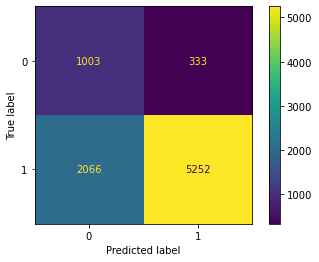

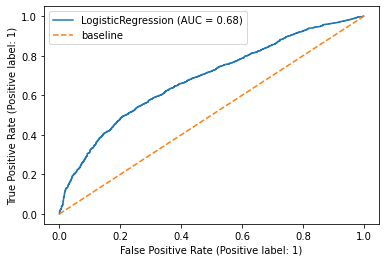

In [43]:
#getting the test metrics ready
test_f1score=f1_score(y_test,preds)
test_precision=precision_score(y_test,preds)
test_accuracy=accuracy_score(y_test,preds)
test_recall=recall_score(y_test,preds)
test_roc_auc=roc_auc_score(y_test,preds)
test_specificity = specificity_score(y_test,preds)

#getting the train metrics
train_f1score=f1_score(y_train,train_preds)
train_specificity = specificity_score(y_train,train_preds)
train_precision=precision_score(y_train,train_preds)
train_accuracy=accuracy_score(y_train,train_preds)
train_recall=recall_score(y_train,train_preds)
train_roc_auc=roc_auc_score(y_train,train_preds)
#printing results-----------------------------------------------------------------

print(f'best params : {lr.get_params}')

print(f'Test_f1_score : {test_f1score}')
print(f'Test_precision score : {test_precision}')
print(f'Test_accuracy score : {test_accuracy}')
print(f'Test_recall score : {test_recall}')
print(f'Test_roc_auc score : {test_roc_auc}')
        
# #update various metrics onto results list-------------------------------------------------------------
score_dict_passengers['lr_2nd_round'] = {
        'Train_acc':train_accuracy,
        'Test_acc':test_accuracy,
        'Train_recall':train_recall,
        'Test_recall':test_recall,
        'Train_preci':train_precision,
        'Test_preci':test_precision,
        'Train_f1score':train_f1score,
        'Test_f1score':test_f1score,
        'Train_roc_auc':train_roc_auc,
        'Test_roc_auc':test_roc_auc,
        'Train_specificity': train_specificity,
        'Test_specificity':test_specificity
        }

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test,preds)
displ = ConfusionMatrixDisplay(cm)
displ.plot();

plot_roc_curve(lr, X_test, y_test)
plt.plot([0, 1], [0, 1],
label='baseline', linestyle='--') # to simulate random guess 
plt.legend();

In [44]:
pd_features = pd.DataFrame({'features_name':X_train.columns, 'coefs':lr.coef_[0]})
pd_features.sort_values(by='coefs', ascending=False)

,features_name,coefs
62,was_doing_straight_line,0.246524
63,was_doing_turning,0.236421
6,travelling_direction_unidirectional,0.228695
17,impact_location_rear,0.228332
9,collision_type_three_or_more_vehicules_chain,0.226883
...,...,...
22,in_out_city_out_of_city,-0.237959
67,age_group_60_80,-0.252735
86,road_location_accident_road_side,-0.268816
29,vehicule_type_moto,-0.279428


#### AdaBoost

Fitting 3 folds for each of 4 candidates, totalling 12 fits
best params : {'learning_rate': 1, 'n_estimators': 150}
Test_f1_score : 0.9172710352352225
Test_precision score : 0.8648190729759168
Test_accuracy score : 0.8510515368615669
Test_recall score : 0.9764963104673408
Test_roc_auc score : 0.5702092330779818
CPU times: total: 11.2 s
Wall time: 1min 7s


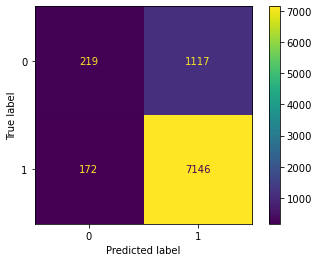

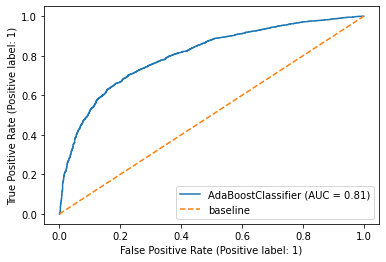

In [45]:
%%time
model = meta_func (
    model=AdaBoostClassifier(random_state=42)
,
    model_name='abc_2nd_round',
    param_grid=
{
    'n_estimators': [150,300], 
    'learning_rate': [1, 2]
    }
,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_passengers
)

In [46]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.feature_importances_})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
3,hour,0.093333
0,speed_group,0.080000
2,num_operating_lanes,0.080000
22,in_out_city_out_of_city,0.046667
17,impact_location_rear,0.033333
...,...,...
44,road_incline_hill_top,0.000000
88,road_location_accident_special_lane,0.000000
25,vehicule_type_electric_bike,0.000000
24,vehicule_type_car,0.000000


#### XGBoost

Fitting 3 folds for each of 8 candidates, totalling 24 fits
best params : {'learning_rate': 0.5, 'max_depth': 3, 'min_split_loss': 2}
Test_f1_score : 0.9174005270939127
Test_precision score : 0.8661245296759316
Test_accuracy score : 0.8515137508666513
Test_recall score : 0.9751298168898607
Test_roc_auc score : 0.5747655072473256
CPU times: total: 25.1 s
Wall time: 52.8 s


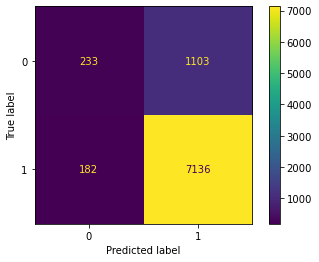

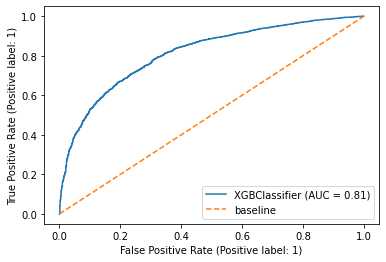

In [47]:
%%time
model = meta_func (
    model=XGBClassifier(random_state=42)
,
    model_name='xgb_2nd_round',
    param_grid=
{
    'learning_rate': [0.5,1], 
    'min_split_loss': [1,2], #The larger gamma is, the more conservative the algorithm will be
    'max_depth':[2,3] #Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
     # Beware that XGBoost aggressively consumes memory when training a deep tree
    }
,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_passengers
)

In [48]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.feature_importances_})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
85,road_location_accident_road,0.118704
22,in_out_city_out_of_city,0.059219
54,was_doing_lurch,0.052949
80,road_type_urban_rd,0.052729
17,impact_location_rear,0.045072
...,...,...
38,vehicule_type_train,0.000000
37,vehicule_type_tractor,0.000000
30,vehicule_type_others,0.000000
88,road_location_accident_special_lane,0.000000


#### Linear Support Vectors Classifiers

Fitting 3 folds for each of 24 candidates, totalling 72 fits
best params : {'lsvc__C': 0.1, 'lsvc__dual': True, 'lsvc__max_iter': 500, 'lsvc__penalty': 'l2'}
Test_f1_score : 0.8146828777201269
Test_precision score : 0.9401251117068812
Test_accuracy score : 0.7234804714582852
Test_recall score : 0.7187756217545778
Test_roc_auc score : 0.7340135593802829
CPU times: total: 10.4 s
Wall time: 2min 10s


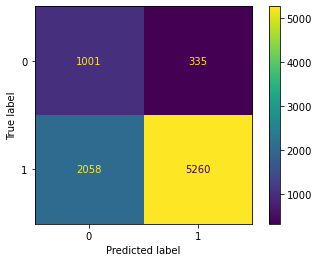

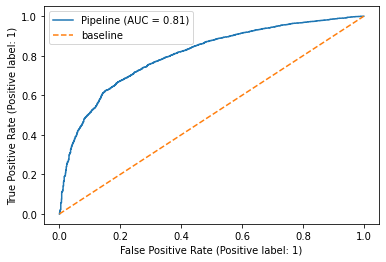

In [49]:
%%time
model = meta_func (
    model=Pipeline(
        [
            ('ss',StandardScaler()),
            ('lsvc', LinearSVC(class_weight='balanced'))
        ]
    ),
    model_name='lsvc_2nd_round',
    param_grid=
{   'lsvc__max_iter':[500,1000],
    'lsvc__C': [0.001,0.01,0.1], 
    'lsvc__dual': [True, False],     
    'lsvc__penalty':['l1','l2']   
},
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    score_dict= score_dict_passengers
)

In [50]:
pd_features = pd.DataFrame({'Features': X_train.columns,'Coef_': model.best_estimator_.steps[-1][1].coef_[0]})
pd_features.sort_values(by='Coef_', ascending=False)

,Features,Coef_
109,road_surface_wet,0.120018
104,road_surface_normal,0.116721
62,was_doing_straight_line,0.111586
63,was_doing_turning,0.101804
9,collision_type_three_or_more_vehicules_chain,0.093139
...,...,...
76,road_type_national_rd,-0.129269
80,road_type_urban_rd,-0.139361
29,vehicule_type_moto,-0.160746
0,speed_group,-0.163694


In [51]:
passengers_score_df= pd.DataFrame(score_dict_passengers).T
passengers_score_df.sort_values(by= 'Test_specificity', ascending=False)

,Train_acc,Test_acc,Train_recall,Test_recall,Train_preci,Test_preci,Train_f1score,Test_f1score,Train_roc_auc,Test_roc_auc,Train_specificity,Test_specificity
lr_2nd_round,0.716263,0.722787,0.711059,0.717682,0.938492,0.940376,0.809097,0.814074,0.727910,0.734215,0.744760,0.750749
lsvc_2nd_round,0.716292,0.723480,0.710684,0.718776,0.938970,0.940125,0.809031,0.814683,0.728845,0.734014,0.747006,0.749251
lr_1st_round,0.716638,0.721863,0.711709,0.717136,0.938291,0.939660,0.809442,0.813454,0.727673,0.732445,0.743638,0.747754
lsvc_1st_round,0.715829,0.721747,0.710240,0.716999,0.938807,0.939649,0.808683,0.813362,0.728342,0.732377,0.746445,0.747754
xgb_2nd_round,0.855141,0.851514,0.978612,0.975130,0.867155,0.866125,0.919518,0.917401,0.578752,0.574766,0.178892,0.174401
abc_1st_round,0.847254,0.851398,0.975196,0.976360,0.862222,0.865222,0.915236,0.917437,0.560858,0.571638,0.146519,0.166916
abc_2nd_round,0.847341,0.851052,0.975366,0.976496,0.862191,0.864819,0.915293,0.917271,0.560756,0.570209,0.146145,0.163922
xgb_1st_round,0.851472,0.852207,0.978988,0.978273,0.863593,0.864718,0.917677,0.917997,0.566028,0.569975,0.153069,0.161677


In [52]:
#exporting scoring file to AWS S3
bucket = aws_creds.bucket # already created on S3
csv_buffer = StringIO()
passengers_score_df.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'passengers_scores.csv').put(Body=csv_buffer.getvalue()) 

{'ResponseMetadata': {'RequestId': 'XNVFEVZV11980V45',
  'HostId': 'e/kDosgwH0yBDarBuDzlwCJQlPPCrHrUHAbgupgUQuqW4CXrszxfQgeqTi6oeOG1aaAdgU93FUA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'e/kDosgwH0yBDarBuDzlwCJQlPPCrHrUHAbgupgUQuqW4CXrszxfQgeqTi6oeOG1aaAdgU93FUA=',
   'x-amz-request-id': 'XNVFEVZV11980V45',
   'date': 'Thu, 08 Dec 2022 08:50:18 GMT',
   'etag': '"577bc966ee26a48c8cb23a3f7763c4ca"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 1},
 'ETag': '"577bc966ee26a48c8cb23a3f7763c4ca"'}

In [53]:
et = time.time() # end time
elapsed_time = et - st
print('Execution time:', elapsed_time/60, 'minutes')

Execution time: 10.77948175271352 minutes
